In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display_html


In [2]:

def display_dfs(dfs, gap=50, justify='center'):
    html = ""
    for title, df in dfs.items():  
        df_html = df._repr_html_()
        cur_html = f'<div> <h3>{title}</h3> {df_html}</div>'
        html +=  cur_html
    html= f"""
    <div style="display:flex; gap:{gap}px; justify-content:{justify};">
        {html}
    </div>
    """
    display_html(html, raw=True)

In [3]:
d=pd.read_csv('../datasets/datasets_final.csv')


In [4]:
def mynorm(arr):
    return (arr-arr.min())/(arr.max() - arr.min())

In [5]:
def remove_outliers(d,cols_=['y']):
    d=d.copy()
    cols = cols_ # one or more

    Q1 = d[cols].quantile(0.25)
    Q3 = d[cols].quantile(0.75)
    IQR = Q3 - Q1

    d = d[~((d[cols] < (Q1 - 2 * IQR)) |(d[cols] > (Q3 + 2 * IQR))).any(axis=1)]
    d['y'] = mynorm(d.y)
    return d

In [6]:
def plot_corr(df,var):
    sns.regplot(x=mynorm(df[var]),y=mynorm(df.y),order=1)
    plt.show()

In [7]:

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

In [8]:
df = d[d.channel.isin(list(d.groupby('channel').count().sort_values(by='id').reset_index()['channel'][-14:]))]
df = d.copy()
df = df[df.access_level != 'conditional']
df.y = mynorm(df.y)


# Different setups

## granularity

In [9]:
df['seo_bias_metric']=df[['seo_loaded','seo_subj','seo_mb','seo_pers','seo_veracity']].mean(axis=1)
df['body_bias_metric']=df[['body_mb','body_pers']].mean(axis=1)
df['title_bias'] = df[['seo_loaded','seo_subj','seo_mb','seo_pers','seo_veracity','loaded','subj','mb','pers','veracity']].mean(axis=1)


In [10]:
df['month'] = df.publish_date_cest.apply(lambda x: str(x)[5:7])
df['day'] = df.publish_date_cest.apply(lambda x: str(x)[:10])

df_sorted=df.sort_values(by='day')
df_sorted_f=df_sorted[df_sorted.access_level=='free'].groupby('day').mean()
df_sorted_p=df_sorted[df_sorted.access_level=='paid'].groupby('day').mean()

In [11]:
gbm = df.groupby(by='month').mean()
gbw = df_sorted.groupby(np.arange(len(df_sorted))//7, axis=0).mean()


In [12]:
gbmp = df[df.access_level=='paid'].groupby(by='month').mean()
gbdp = df[df.access_level=='paid'].groupby(by='day').mean()
gbmf = df[df.access_level=='free'].groupby(by='month').mean()
gbdf = df[df.access_level=='free'].groupby(by='day').mean()
gbwf =df_sorted_f.groupby(np.arange(len(df_sorted_f.index))//7, axis=0).mean()
gbwp = df_sorted_p.groupby(np.arange(len(df_sorted_p.index))//7, axis=0).mean()

In [13]:
gbwf.corr()['y'].sort_values()

subj2              -0.491672
loaded             -0.413086
seo_loaded         -0.410688
seo_pers           -0.395369
body_pers          -0.393169
veracity           -0.381767
seo_mb             -0.347622
pers               -0.310735
seo_veracity       -0.295490
seo_bias_metric    -0.278072
sent               -0.266379
title_bias         -0.214218
body_bias_metric   -0.164373
seo_subj2          -0.112920
seo_sent           -0.055184
complexity         -0.021312
seo_complexity     -0.017078
body_mb             0.088960
subj                0.178088
seo_subj            0.218249
mb                  0.424945
y                   1.000000
Name: y, dtype: float64

In [14]:
calculate_pvalues(gbwp)['y'].sort_values()

seo_sent               0.0
y                      0.0
mb                  0.0003
seo_subj            0.0015
seo_bias_metric     0.0028
title_bias          0.0028
veracity            0.0103
seo_loaded          0.0205
loaded              0.0237
seo_mb              0.0271
seo_veracity        0.0302
seo_subj2           0.0346
complexity          0.3038
subj2               0.3949
seo_complexity      0.4789
body_pers           0.5494
body_mb             0.5887
subj                0.6094
sent                0.7631
seo_pers            0.7854
pers                0.8682
body_bias_metric    0.9508
Name: y, dtype: object

In [16]:
def plot_by_topic(d):
    d['month'] = d.publish_date_cest.apply(lambda x: str(x)[5:7])
    d['day'] = d.publish_date_cest.apply(lambda x: str(x)[:10])

    topics = d.groupby('channel').count().sort_values(by='id').reset_index()['channel'][-14:]

    for topic in topics:
        print(topic)
        
        df = d[d.channel == topic]
        print("Full length:",len(df))


        df = df[['seo_bias_metric','body_bias_metric','complexity','y','day','month','access_level','publish_date_cest','seo_loaded','seo_subj','seo_mb','seo_pers','seo_veracity']]

        df_sorted=df.sort_values(by='day')
        df_sorted_f=df_sorted[df_sorted.access_level=='free'].groupby('day').mean()
        df_sorted_p=df_sorted[df_sorted.access_level=='paid'].groupby('day').mean()
        print("Free to paid ratio:",len(df_sorted_f)/(len(df_sorted_p)+len(df_sorted_f)))
        df_sorted_fp = df_sorted.groupby('day').mean()


        gbwf =df_sorted_f.groupby(np.arange(len(df_sorted_f.index))//7, axis=0).mean()
        gbwp = df_sorted_p.groupby(np.arange(len(df_sorted_p.index))//7, axis=0).mean()
        gbw = df_sorted_fp.groupby(np.arange(len(df_sorted_fp.index))//7, axis=0).mean()
        gbwf_corrs = remove_outliers(gbwf).corr().y.sort_values().reset_index()
        gbwp_corrs = remove_outliers(gbwp).corr().y.sort_values().reset_index()
        gbw_corrs = remove_outliers(gbw).corr().y.sort_values().reset_index()
        print("Final number of months:",len(remove_outliers(gbw)))

        dfs = {'free':gbwf_corrs,'paid':gbwp_corrs, 'both':gbw_corrs}
        display_dfs(dfs, justify='flex-start')

In [17]:
def get_topic_week(df,topic):
    df = df[df.channel == topic]

    df = df[['seo_bias_metric','body_bias_metric','complexity','y','day','month','access_level','publish_date_cest','seo_loaded','seo_subj','seo_mb','seo_pers','seo_veracity']]

    df_sorted=df.sort_values(by='day')
    df_sorted_f=df_sorted[df_sorted.access_level=='free'].groupby('day').mean()
    df_sorted_p=df_sorted[df_sorted.access_level=='paid'].groupby('day').mean()
    df_sorted_fp = df_sorted.groupby('day').mean()


    gbwf = remove_outliers(df_sorted_f.groupby(np.arange(len(df_sorted_f.index))//7, axis=0).mean())
    gbwp = remove_outliers(df_sorted_p.groupby(np.arange(len(df_sorted_p.index))//7, axis=0).mean())
    gbw = remove_outliers(df_sorted_fp.groupby(np.arange(len(df_sorted_fp.index))//7, axis=0).mean())

    return gbwf,gbwp,gbw

In [19]:
plot_by_topic(df)

Gesundheit
Full length: 298
Free to paid ratio: 0.4819277108433735
Final number of months: 29


,index,y
0,body_bias_metric,-0.186521
1,seo_veracity,0.002596
2,complexity,0.061564
3,seo_mb,0.208746
4,seo_subj,0.238995
5,seo_pers,0.279049
6,seo_bias_metric,0.287033
7,seo_loaded,0.435368
8,y,1.000000
,index,y


International
Full length: 316
Free to paid ratio: 0.9835164835164835
Final number of months: 26


,index,y
0,seo_loaded,-0.446128
1,seo_mb,-0.122131
2,seo_bias_metric,-0.085415
3,seo_pers,-0.064067
4,seo_subj,-0.041314
5,complexity,0.159664
6,body_bias_metric,0.241996
7,seo_veracity,0.284812
8,y,1.000000
,index,y


Psychologie
Full length: 323
Free to paid ratio: 0.17338709677419356
Final number of months: 33


,index,y
0,seo_mb,-0.552650
1,seo_veracity,-0.519086
2,seo_bias_metric,-0.476035
3,seo_subj,-0.443556
4,complexity,-0.282961
5,seo_loaded,-0.212641
6,seo_pers,0.203807
7,body_bias_metric,0.734895
8,y,1.000000
,index,y


Job & Karriere
Full length: 329
Free to paid ratio: 0.6105263157894737
Final number of months: 37


,index,y
0,complexity,-0.450040
1,seo_pers,-0.148053
2,seo_loaded,-0.045659
3,seo_mb,-0.035416
4,seo_bias_metric,-0.022881
5,body_bias_metric,0.015398
6,seo_veracity,0.045356
7,seo_subj,0.057104
8,y,1.000000
,index,y


Mobilität
Full length: 387
Free to paid ratio: 0.48417721518987344
Final number of months: 36


,index,y
0,seo_pers,-0.028908
1,seo_loaded,0.085405
2,seo_subj,0.125858
3,seo_veracity,0.206556
4,body_bias_metric,0.222026
5,seo_bias_metric,0.238073
6,seo_mb,0.269291
7,complexity,0.416413
8,y,1.000000
,index,y


Geschichte
Full length: 632
Free to paid ratio: 0.22658610271903323
Final number of months: 39


,index,y
0,seo_subj,-0.573797
1,seo_pers,-0.278033
2,seo_bias_metric,-0.277986
3,seo_veracity,-0.180396
4,seo_mb,-0.064112
5,body_bias_metric,-0.033635
6,seo_loaded,0.003734
7,complexity,0.101671
8,y,1.000000
,index,y


Netzwelt
Full length: 1049
Free to paid ratio: 0.7097505668934241
Final number of months: 47


,index,y
0,complexity,-0.145494
1,seo_mb,-0.078154
2,seo_veracity,0.013404
3,seo_pers,0.026215
4,body_bias_metric,0.055429
5,seo_bias_metric,0.058869
6,seo_subj,0.096315
7,seo_loaded,0.185745
8,y,1.000000
,index,y


Wissenschaft
Full length: 2142
Free to paid ratio: 0.5382215288611545
Final number of months: 51


,index,y
0,complexity,-0.228598
1,body_bias_metric,-0.221269
2,seo_mb,-0.047596
3,seo_pers,-0.000593
4,seo_subj,0.003509
5,seo_bias_metric,0.030982
6,seo_veracity,0.091000
7,seo_loaded,0.124563
8,y,1.000000
,index,y


Kultur
Full length: 2318
Free to paid ratio: 0.5568181818181818
Final number of months: 49


,index,y
0,complexity,-0.062226
1,seo_veracity,0.025020
2,seo_mb,0.048858
3,seo_loaded,0.124519
4,seo_bias_metric,0.173990
5,seo_subj,0.190626
6,seo_pers,0.191037
7,body_bias_metric,0.319746
8,y,1.000000
,index,y


Sport
Full length: 3904
Free to paid ratio: 0.5199409158050221
Final number of months: 50


,index,y
0,complexity,-0.189908
1,seo_veracity,-0.078405
2,seo_loaded,0.072796
3,seo_mb,0.114149
4,seo_subj,0.124094
5,seo_bias_metric,0.167026
6,seo_pers,0.362166
7,body_bias_metric,0.526058
8,y,1.000000
,index,y


Politik
Full length: 4531
Free to paid ratio: 0.5139500734214391
Final number of months: 51


,index,y
0,seo_pers,-0.272092
1,seo_mb,-0.088647
2,seo_loaded,-0.005234
3,body_bias_metric,0.076154
4,seo_bias_metric,0.169121
5,seo_subj,0.238606
6,complexity,0.367690
7,seo_veracity,0.422700
8,y,1.000000
,index,y


Wirtschaft
Full length: 5023
Free to paid ratio: 0.5214814814814814
Final number of months: 50


,index,y
0,seo_mb,-0.135407
1,seo_pers,-0.010484
2,body_bias_metric,0.091377
3,seo_subj,0.096154
4,seo_bias_metric,0.115857
5,seo_veracity,0.142173
6,seo_loaded,0.256515
7,complexity,0.278253
8,y,1.000000
,index,y


Panorama
Full length: 6668
Free to paid ratio: 0.5532915360501567
Final number of months: 51


,index,y
0,complexity,-0.187024
1,body_bias_metric,-0.149771
2,seo_subj,-0.109240
3,seo_veracity,-0.108522
4,seo_bias_metric,-0.086526
5,seo_loaded,0.004328
6,seo_pers,0.019996
7,seo_mb,0.054742
8,y,1.000000
,index,y


Ausland
Full length: 7093
Free to paid ratio: 0.5007112375533428
Final number of months: 50


,index,y
0,complexity,-0.345521
1,seo_loaded,-0.144450
2,seo_pers,0.024583
3,seo_mb,0.064423
4,body_bias_metric,0.226595
5,seo_bias_metric,0.413634
6,seo_subj,0.488229
7,seo_veracity,0.531083
8,y,1.000000
,index,y


In [210]:
d.groupby('channel').count().sort_values(by='id').reset_index()['channel'][-14:]


12     International
13        Gesundheit
14    Job & Karriere
15       Psychologie
16         Mobilität
17        Geschichte
18          Netzwelt
19      Wissenschaft
20            Kultur
21             Sport
22           Politik
23        Wirtschaft
24          Panorama
25           Ausland
Name: channel, dtype: object

<AxesSubplot: >

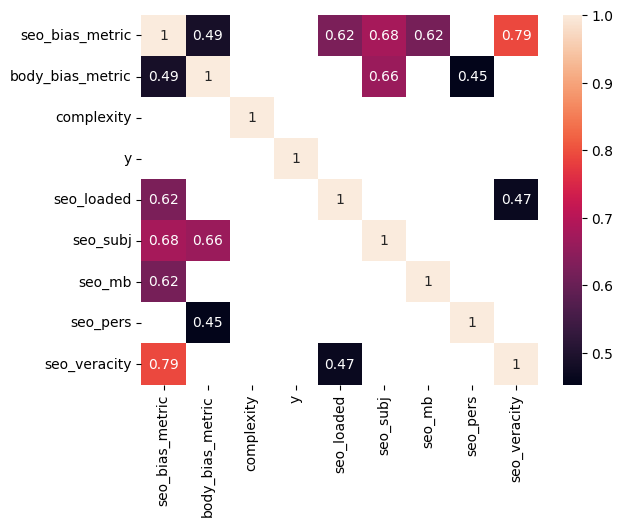

In [20]:
gbwf,gbwp,gbw = get_topic_week(df,'Mobilität')
mask=(calculate_pvalues(gbwf)>0.05).astype(int)
sns.heatmap(gbwf.corr(),mask=mask,annot=True)

In [221]:
mask=(calculate_pvalues(gbw)>0.05).astype(int)

,seo_bias_metric,body_bias_metric,complexity,y,seo_loaded,seo_subj,seo_mb,seo_pers,seo_veracity
seo_bias_metric,0,0,0,1,0,0,0,0,0
body_bias_metric,0,0,0,0,1,1,1,0,0
complexity,0,0,0,0,1,0,0,1,0
y,1,0,0,0,1,1,1,1,1
seo_loaded,0,1,1,1,0,1,1,0,1
seo_subj,0,1,0,1,1,0,0,0,1
seo_mb,0,1,0,1,1,0,0,0,1
seo_pers,0,0,1,1,0,0,0,0,1
seo_veracity,0,0,0,1,1,1,1,1,0


In [241]:
df[df.channel=='Ausland'].subchannel

array(['default'], dtype=object)

<AxesSubplot: xlabel='body_bias_metric', ylabel='y'>

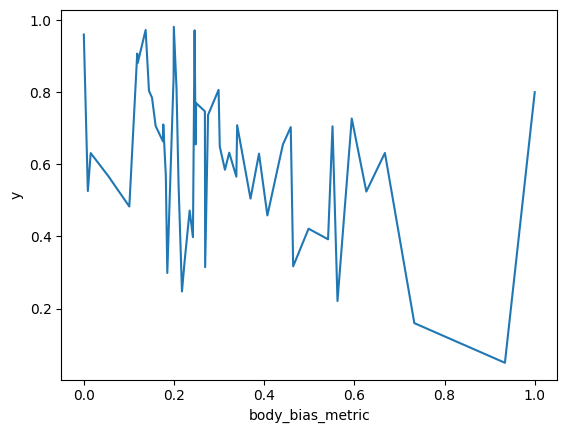

In [274]:
sns.lineplot(x=mynorm(gbw.body_bias_metric),y=mynorm(gbw['y']).ewm(alpha=0.8).mean())

<AxesSubplot: ylabel='y'>

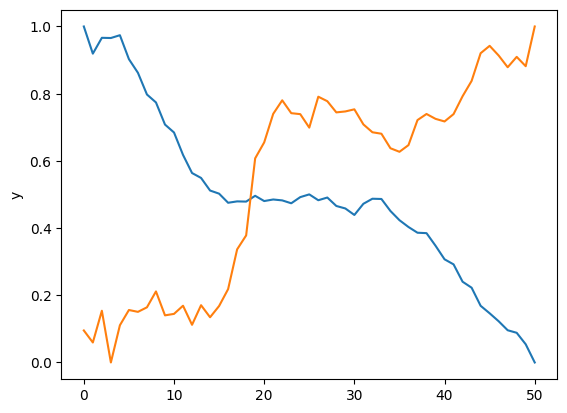

In [318]:
sns.lineplot(mynorm(gbw['y'].ewm(alpha=0.05).mean()))
sns.lineplot(mynorm(gbw['body_bias_metric'].ewm(alpha=0.05).mean()))

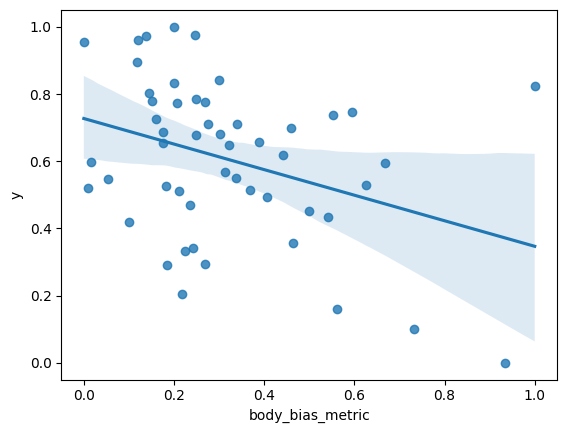

In [310]:
gbwf,gbwp,gbw = get_topic_week(df,'Wissenschaft')

plot_corr(gbw,'body_bias_metric')

In [158]:
gbw

,seo_bias_metric,body_bias_metric,complexity,y,seo_loaded,seo_subj,seo_mb,seo_pers,seo_veracity
0,0.440252,0.235902,0.333333,0.746563,0.172117,0.624741,0.602648,0.441279,0.360474
1,0.380994,0.247198,0.000000,0.075023,0.159734,0.577991,0.453584,0.248538,0.465124
2,0.480818,0.298517,0.214286,0.321637,0.307731,0.797629,0.481271,0.375545,0.441912
3,0.386287,0.267601,0.196429,0.826762,0.171384,0.668234,0.335598,0.199145,0.557075
4,0.492981,0.282507,0.095238,0.341869,0.258604,0.826782,0.435746,0.366243,0.577529
5,0.483172,0.327948,0.247619,0.851326,0.224261,0.777498,0.469038,0.352970,0.592095
6,0.381739,0.258393,0.047619,0.411959,0.132749,0.617101,0.460874,0.282044,0.415930
7,0.474906,0.306569,0.333333,0.926651,0.252281,0.696030,0.496240,0.407567,0.522411
8,0.387309,0.296546,0.214286,0.483952,0.116715,0.639384,0.480370,0.248964,0.451111
9,0.504324,0.282477,0.595238,0.120432,0.394137,0.722449,0.519037,0.344352,0.541647


# Datasets

In [ ]:
d.columns

In [ ]:
d = d[['id','channel','subchannel','access_level','title','seo_title','body','merged','y']]

## All topics

In [ ]:
d['y'].describe()

In [ ]:
def remove_outliers(d):
    cols = ['y'] # one or more

    Q1 = d[cols].quantile(0.25)
    Q3 = d[cols].quantile(0.75)
    IQR = Q3 - Q1

    d = d[~((d[cols] < (Q1 - 2 * IQR)) |(d[cols] > (Q3 + 2 * IQR))).any(axis=1)]
    d['y'] = mynorm(d.y)
    return d

In [ ]:
d = remove_outliers(d)

### ALL

In [ ]:
d.to_csv('../datasets/all_all_regression.csv')

In [ ]:
d

In [ ]:
def split_(num):
    if num <= 0.40521:
        return 0
    elif num > 0.40521 and num <= 0.604366:
        return 1
    elif num > 0.604366:
        return 2
    else:
        print("Err")

In [ ]:
d['y_disc'] = d.y.apply(split_)

In [ ]:
d.to_csv('../datasets/all_all.csv')

In [ ]:
d0 = d[d.y_disc==0]
d1 = d[d.y_disc==1].sample(len(d0),random_state=42)
d2 = d[d.y_disc==2]

d_sampled = pd.concat([d0,d1,d2]).sample(frac=1,random_state=42)

d_sampled.to_csv('../datasets/all_all_sampled.csv')

In [ ]:
d_sampled[d_sampled.access_level=='paid'][['id','seo_title','merged','y_disc']].to_csv('all_paid_sampled.csv')

In [ ]:
mynorm(d_sampled[d_sampled.access_level=='paid'].y).describe()

In [ ]:
fre = d_sampled[d.access_level=='free']
fre['y'] = mynorm(fre.y)

In [ ]:
fre = fre[fre.y_disc!=1]#[['id','seo_title','merged','y_disc']]

In [ ]:
fre[fre.y_disc==2].channel.value_counts()

In [ ]:
fre[fre.y_disc==0].channel.value_counts()

In [ ]:
fre['y_disc'] = fre.y_disc.apply(lambda x: 1 if x==2 else 0)

In [ ]:
fre.to_csv('lowhigh_free.csv')

In [ ]:
fre

### PAID x FREE

In [ ]:
fre = d[d.access_level=='free']
fre['y'] = mynorm(fre.y)
fre.to_csv('../datasets/all_free_regression.csv')

paid = d[d.access_level=='paid']
paid['y'] = mynorm(paid.y)
paid.to_csv('../datasets/all_paid_regression.csv')